## Read normalization techniques

This notebook is designed to demonstrate different means of read normaliztion from a mapped and annotated RNA-seq dataset. The Python commands are already pre-run, but if you should want to try for yourself, feel free to start up a [Jupyter notebook](https://github.com/biom262/biom262-2018/blob/master/Module1_Unix_RNASeq/Tutorials/How_to_load_jupyter_notebooks.ipynb) and give it a try!

In [60]:
import pandas as pd

#We will use numpy to calculate lograthims
import numpy as np

#We will use seaborn and matplotlib for plotting
import seaborn as sns
from matplotlib import pyplot as plt

###NOTE - you will probably get an error saying package seaborn not found. So you need to install it!
###How do you install packages???? After you install, refresh this page and try loading it again.

#This line will allow our plots to show in this notebook
%matplotlib inline

Let's practice on a dummy dataframe first:

In [61]:
raw_counts = pd.DataFrame({"Replicate 1": [10,20,5,0],
                         "Replicate 2": [12,25,8,0],
                         "Replicate 3" :[30,60,15,1]},
                         index = ["Gene A","Gene B","Gene C","Gene D"])


# Let's also add a column for gene length
raw_counts['Gene length (kb)'] = [2,4,1,10]

raw_counts

,Replicate 1,Replicate 2,Replicate 3,Gene length (kb)
Gene A,10,12,30,2
Gene B,20,25,60,4
Gene C,5,8,15,1
Gene D,0,0,1,10


## FPKM (RPKM)

Notice immediately that Replicate 3 is sequenced deeper, meaning that its library has greater read depth and thus more counts. We need to normalize for overall read depth.

In [62]:
# Calculation of total reads 

reps = raw_counts.columns[0:3]
raw_counts[reps].sum(axis=0)

Replicate 1     35
Replicate 2     45
Replicate 3    106
dtype: int64

In [63]:
# Now, I am taking my total reads, scaling by dividing it by 10 (normally a million), and dividing each count by that 
# number, which will give me an RPM (reads per million) value
RPM = raw_counts[reps].divide((raw_counts[reps].sum(axis=0))/10)
RPM

,Replicate 1,Replicate 2,Replicate 3
Gene A,2.857143,2.666667,2.830189
Gene B,5.714286,5.555556,5.660377
Gene C,1.428571,1.777778,1.415094
Gene D,0.000000,0.000000,0.094340


I can now divide each of these values by their respective gene length to generate FPKM:

In [64]:
FPKM = RPM.divide(raw_counts["Gene length (kb)"],axis=0)
FPKM

,Replicate 1,Replicate 2,Replicate 3
Gene A,1.428571,1.333333,1.415094
Gene B,1.428571,1.388889,1.415094
Gene C,1.428571,1.777778,1.415094
Gene D,0.000000,0.000000,0.009434


## TPM

We can also use this raw reads database to calculate TPM, or transcripts per million. This is an alternate way of normalizing for both sequencing depth and gene length, but will alter the order of the steps mentioned with FPKM.

In [65]:
raw_counts

,Replicate 1,Replicate 2,Replicate 3,Gene length (kb)
Gene A,10,12,30,2
Gene B,20,25,60,4
Gene C,5,8,15,1
Gene D,0,0,1,10


Let's begin by FIRST normalizing to gene length:

In [66]:

# Dividing each read count by its respective gene length 
RPK = raw_counts[reps].divide(raw_counts["Gene length (kb)"],axis = 0)
RPK

,Replicate 1,Replicate 2,Replicate 3
Gene A,5.0,6.00,15.0
Gene B,5.0,6.25,15.0
Gene C,5.0,8.00,15.0
Gene D,0.0,0.00,0.1


Next, I want to add up ALL of these RPKs and scale them, as I did for RPM in the FPKM calculation. I will refer to this as my scaling factor:

In [67]:
scaling_factor = RPK.sum(axis=0) / 10
scaling_factor

Replicate 1    1.500
Replicate 2    2.025
Replicate 3    4.510
dtype: float64

Lastly, I will divide each of my RPK values by this scaling factor to calculate TPMs for my dataset: 

In [68]:
TPM = RPK.divide(scaling_factor,axis=1)
TPM

,Replicate 1,Replicate 2,Replicate 3
Gene A,3.333333,2.962963,3.325942
Gene B,3.333333,3.086420,3.325942
Gene C,3.333333,3.950617,3.325942
Gene D,0.000000,0.000000,0.022173


The difference is the total FPKM vs the total TPM. Totaled TPM values will be the same across all replicates. This makes it slightly better than FPKM as a normalization method, as it allows you to see what proportion of the library that each gene took up: 

In [69]:
FPKM_total = FPKM.sum(axis=0)
FPKM_total

Replicate 1    4.285714
Replicate 2    4.500000
Replicate 3    4.254717
dtype: float64

In [70]:
# Total TPMs are the same across replicates 

TPM_total = TPM.sum(axis=0)
TPM_total

Replicate 1    10.0
Replicate 2    10.0
Replicate 3    10.0
dtype: float64

## Real example of TPM calculation

Let's now load up a clean dataframe that we made with filtered counts and our length column. I have this saved in a file as a comma separated file (csv), so we will load it with read_csv (instead of read_table that is used for tab separated files). There aren't any comments at the top of the file, so we don't need to use comment = "#". Let's just set the first column as the index with index_col=0. Take a look at the shape and the first 5 rows of the dataframe. 

In [71]:
feature_counts_dir = "/oasis/tscc/scratch/biom200/cmm262/featurecounts/"

counts = pd.read_csv(feature_counts_dir+"tardbp_counts_with_length.csv", index_col=0)
print counts.shape
counts.head()

(16582, 5)


,Length,NT_shRNA_hepg2_Rep1,NT_shRNA_hepg2_Rep2,TARDBP_shRNA_hepg2_Rep1,TARDBP_shRNA_hepg2_Rep2
Geneid,,,,,
ENSG00000227232.4,2073,61,92,69,58
ENSG00000237683.5,2661,23,21,17,28
ENSG00000239906.1,323,11,2,5,7
ENSG00000241860.2,6195,26,32,35,35
ENSG00000228463.4,3954,77,69,63,66


Let's make a function to calculate out TPM. Each of steps can be processsed separtely in different cells of a notebook, but for all intents and purposes let's store it in a function:

In [72]:
#Now let's make a function out of this:

def counts_to_tpm(counts_matrix):
    data_cols = counts_matrix.columns[1:]
    rpk = counts_matrix[data_cols].divide((counts_matrix['Length']/1000), axis=0)
    sums_per_million = rpk.sum(axis=0)/(10**6)
    tpm = rpk.divide(sums_per_million)
    
    return tpm


In [73]:
tpm_from_function = counts_to_tpm(counts)
tpm_from_function.head()

,NT_shRNA_hepg2_Rep1,NT_shRNA_hepg2_Rep2,TARDBP_shRNA_hepg2_Rep1,TARDBP_shRNA_hepg2_Rep2
Geneid,,,,
ENSG00000227232.4,1.915979,2.881630,2.267504,1.831513
ENSG00000237683.5,0.562786,0.512418,0.435213,0.688802
ENSG00000239906.1,2.217432,0.402047,1.054546,1.418655
ENSG00000241860.2,0.273270,0.335396,0.384880,0.369835
ENSG00000228463.4,1.267985,1.133084,1.085431,1.092669


In [86]:
# Even across very large datasets, total TPM are the same across replicates 
tpm_from_function.sum(axis=0)

NT_shRNA_hepg2_Rep1        1000000.0
NT_shRNA_hepg2_Rep2        1000000.0
TARDBP_shRNA_hepg2_Rep1    1000000.0
TARDBP_shRNA_hepg2_Rep2    1000000.0
dtype: float64

In [74]:
# Let's save this data while we're at it (to your training account)
save_dir = '/home/ucsd-train40/projects/tardbp_shrna/featurecounts/'
tpm_from_function.to_csv(save_dir+"tardbp_shrna_tpm.csv")

Let's try plotting our distribution of TPMs with a histogram:

(array([  1.65660000e+04,   4.00000000e+00,   1.00000000e+00,
          3.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          2.00000000e+00]),
 array([     0.        ,   9622.35737194,  19244.71474388,  28867.07211582,
         38489.42948776,  48111.7868597 ,  57734.14423164,  67356.50160358,
         76978.85897552,  86601.21634746,  96223.5737194 ]),
 <a list of 10 Patch objects>)

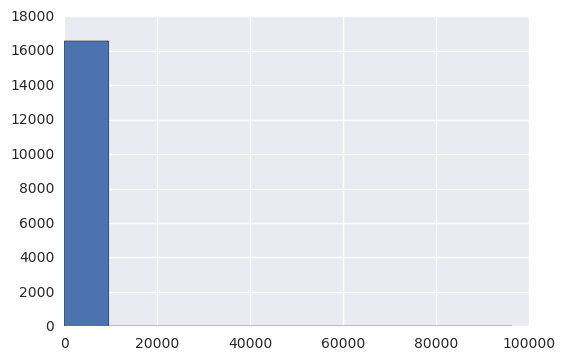

In [75]:
plt.hist(tpm_from_function['TARDBP_shRNA_hepg2_Rep1'])

Not really that pretty or informative since the vast majority of our TPMs are well below the thousands place, but some are. Let's instead log2 transform to get a better representation of our distribution. We need to add an arbitrary value, +1, to this prior to transformation to account for negative values, which will appear as NA. We call this adding a pseudocount:

(array([  5.81100000e+03,   5.44200000e+03,   3.76900000e+03,
          1.19900000e+03,   2.65000000e+02,   6.30000000e+01,
          1.30000000e+01,   4.00000000e+00,   7.00000000e+00,
          9.00000000e+00]),
 array([  0.        ,   1.65541178,   3.31082355,   4.96623533,
          6.6216471 ,   8.27705888,   9.93247065,  11.58788243,
         13.2432942 ,  14.89870598,  16.55411775]),
 <a list of 10 Patch objects>)

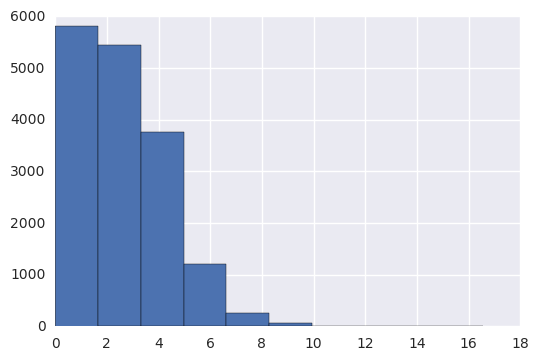

In [76]:
plt.hist(np.log2(tpm_from_function['TARDBP_shRNA_hepg2_Rep1'] + 1))

We can use a plotting feature in seaborn called pairplot to perform pairwise comparison on all of our samples using TPM. This will graph how well certain samples correlate with (or deviate from) one another: 

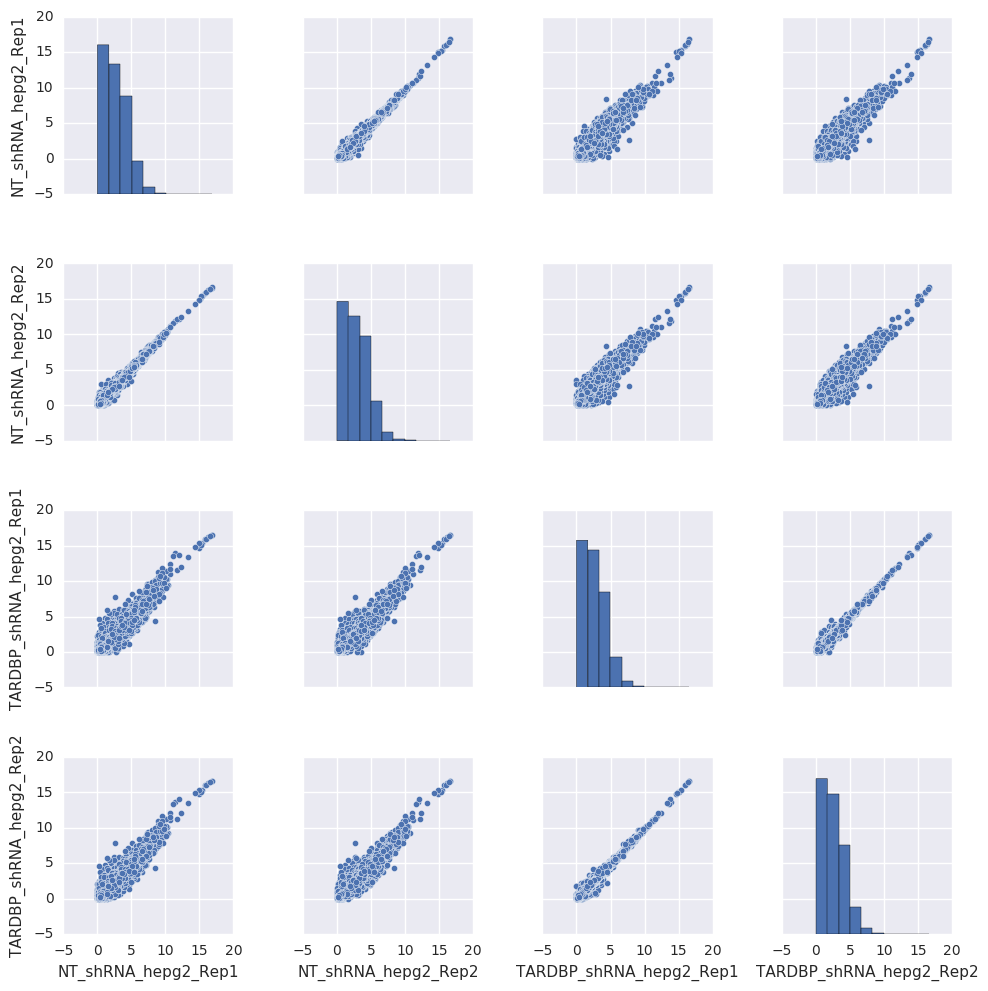

In [77]:
sns.pairplot(np.log2(tpm_from_function+1))

In [78]:
# Log2 normaliztion of our normalized counts 
log2_tpm = np.log2(tpm_from_function+1)

In [79]:
# Pairwise correlation of samples, which can then be plotted on a heat map
log2_tpm.corr()

,NT_shRNA_hepg2_Rep1,NT_shRNA_hepg2_Rep2,TARDBP_shRNA_hepg2_Rep1,TARDBP_shRNA_hepg2_Rep2
NT_shRNA_hepg2_Rep1,1.000000,0.993149,0.953633,0.953689
NT_shRNA_hepg2_Rep2,0.993149,1.000000,0.959157,0.957747
TARDBP_shRNA_hepg2_Rep1,0.953633,0.959157,1.000000,0.994570
TARDBP_shRNA_hepg2_Rep2,0.953689,0.957747,0.994570,1.000000


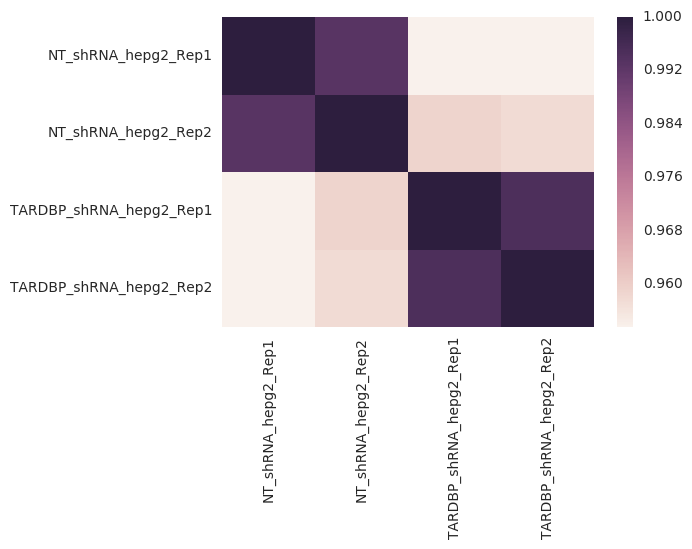

In [80]:
sns.heatmap(log2_tpm.corr())

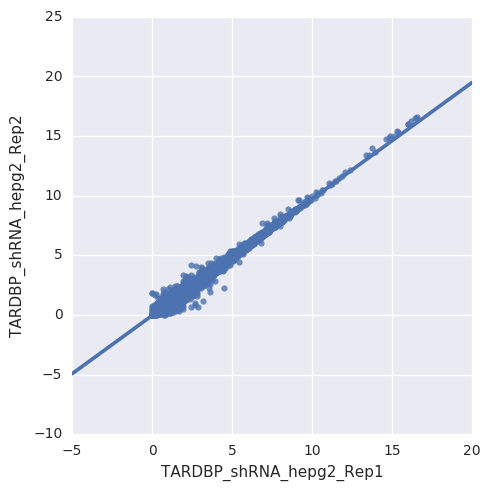

In [81]:
sns.lmplot('TARDBP_shRNA_hepg2_Rep1','TARDBP_shRNA_hepg2_Rep2',log2_tpm)

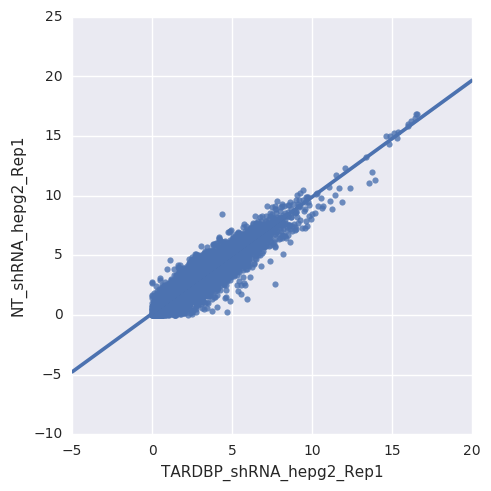

In [82]:
sns.lmplot('TARDBP_shRNA_hepg2_Rep1','NT_shRNA_hepg2_Rep1',log2_tpm)

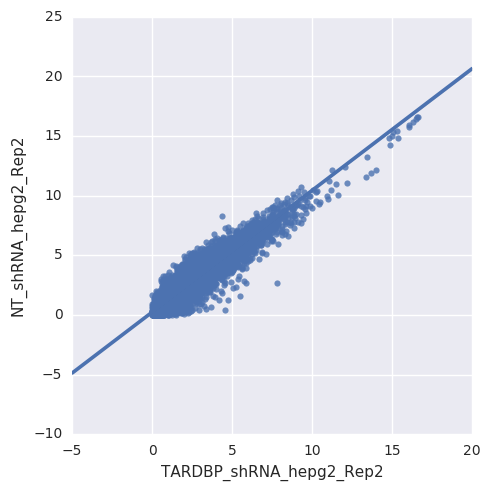

In [83]:
sns.lmplot('TARDBP_shRNA_hepg2_Rep2','NT_shRNA_hepg2_Rep2',log2_tpm)